# Stock Market Prediction

Reading: https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

## Libraries

In [5]:
# Additional python library from python package library
!pip install yfinance

import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
from matplotlib import pyplot as plt
import pickle
import keras
import tensorflow
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
import matplotlib
import yfinance as yf

print(keras.__version__)
print(tensorflow.__version__)
print(np.__version__)
print(matplotlib.__version__)

# Suppress warning and info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2.2.5
1.15.0
1.17.4
3.1.2


In [0]:
def build_timeseries(mat, y_col_index, time_steps=3):
    """
    y_col_index is the index of column that would act as output column
    total number of time-series samples would be len(mat) - time_steps
    """
    
    dim_0 = mat.shape[0] - time_steps
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, time_steps, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:time_steps+i]
        y[i] = mat[time_steps+i, y_col_index]
    
    return x, y

def trim_dataset(mat, batch_size=10):
    """
    trims dataset to a size that's divisible by batch_size
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    
    return mat

# Market Prediction Modeling

## Functions

In [0]:
def preview_data(df, stock_name):
  plt.figure()
  plt.plot(df["Open"])
  plt.plot(df["High"])
  plt.plot(df["Low"])
  plt.plot(df["Close"])
  plt.title(stock_name)
  plt.ylabel('Price')
  plt.xlabel('Days')
  plt.legend(['Open', 'High', 'Low', 'Close'], loc='upper left')
  plt.show()

def datasplit_train_test(df):
  train_cols = ["Open", "High", "Low", "Close", "Volume"]
  df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
  print("Train and Test size", len(df_train), len(df_test))

  # scale the feature MinMax, build array
  x = df_train.loc[:,train_cols].values
  min_max_scaler_test = MinMaxScaler()
  x_train = min_max_scaler_test.fit_transform(x)
  x_test = min_max_scaler_test.transform(df_test.loc[:,train_cols])

  return x_train, x_train, min_max_scaler_test

def time_series(x_train, x_test, batch_size, time_steps):
  x_t, y_t = build_timeseries(x_train, 3, time_steps)
  x_t = trim_dataset(x_t, batch_size)
  y_t = trim_dataset(y_t, batch_size)
  x_temp, y_temp = build_timeseries(x_test, 3, time_steps)
  x_val, x_test_t = np.split(trim_dataset(x_temp, batch_size), 2)
  y_val, y_test_t = np.split(trim_dataset(y_temp, batch_size), 2)

  return x_t, y_t, x_val, y_val, x_test_t, y_test_t

def build_lstm_model(batch_size, time_steps, batch_shape):
  np.random.seed(1)

  model = Sequential()
  model.add(LSTM(
      128,
      batch_input_shape=(batch_size, time_steps, batch_shape),
      dropout=0.0,
      recurrent_dropout=0.0,
      stateful=True,
      kernel_initializer='random_uniform'
      ))
  model.add(Dropout(0.5))
  model.add(Dense(20,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  optimizer = optimizers.RMSprop(lr=0.0001)
  model.compile(loss='mean_squared_error', optimizer=optimizer)

  return model

def training_model(model, x_t, y_t, x_val, y_val, batch_size):
  history = model.fit(
      x_t,
      y_t,
      epochs=300,
      batch_size=batch_size,
      shuffle=False,
      validation_data=(trim_dataset(x_val, batch_size),
                       trim_dataset(y_val, batch_size))
      )
  
  return model, history

def loss_graph(history, stock_name):
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("Model loss %s" % stock_name)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

def validate_model(model, x_test_t, y_test_t, batch_size):
  y_pred = model.predict(trim_dataset(x_test_t, batch_size), batch_size=batch_size)
  y_pred = y_pred.flatten()
  y_test_t = trim_dataset(y_test_t, batch_size)
  error = mean_squared_error(y_test_t, y_pred)

  print("\nError is", error, y_pred.shape, y_test_t.shape)
  print()

  return y_pred, y_test_t

def visualize_prediction(y_pred, y_test_t, min_max_scaler):
  # Visualize the prediction

  y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
  y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)

  plt.figure()
  plt.plot(y_pred_org)
  plt.plot(y_test_t_org)
  plt.title('Prediction vs Real Stock Price')
  plt.ylabel('Price')
  plt.xlabel('Days')
  plt.legend(['Prediction', 'Real'], loc='upper left')

def run(market, batch_size=20, time_steps=60):
  print('======================================================================')
  print('                    STOCK MARKET PREDICTION:', market)
  print('======================================================================\n')
  print('Download the stock data of %s from Yahoo Finance' % market)
  df = yf.download(market, start="2010-01-01", end="2019-12-30")
  print('\n####################      Preview data head      ####################')
  print(df.head())
  print()
  preview_data(df, market)
  x_train, x_test, mmst = datasplit_train_test(df)
  x_t, y_t, x_val, y_val, x_test_t, y_test_t = time_series(x_train, x_test, batch_size, time_steps)
  model = build_lstm_model(batch_size, time_steps, x_t.shape[2])
  model, history = training_model(model, x_t, y_t, x_val, y_val, batch_size)
  loss_graph(history, market)
  y_pred, y_test_t = validate_model(model, x_test_t, y_test_t, batch_size)
  visualize_prediction(y_pred, y_test_t, mmst)

## Input Stock Market data by stock code from Yahoo Finance

                    STOCK MARKET PREDICTION: TATAGLOBAL.NS

Download the stock data of TATAGLOBAL.NS from Yahoo Finance
[*********************100%***********************]  1 of 1 completed

####################      Preview data head      ####################
                  Open        High         Low       Close  Adj Close   Volume
Date                                                                          
2010-01-04   94.500000   95.500000   93.915001   94.925003  80.318420   952740
2010-01-05   95.500000  105.235001   95.099998  102.285004  86.545906  7061550
2010-01-06  103.199997  104.839996  100.419998  103.885002  87.899704  2960980
2010-01-07  104.989998  106.800003  103.300003  104.250000  88.208549  3807800
2010-01-08  104.699997  107.474998  104.110001  104.769997  88.648537  2940330



/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


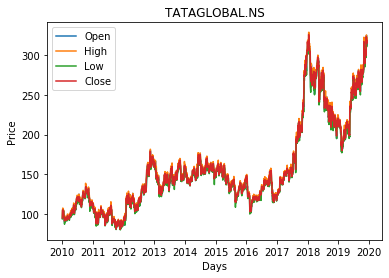

Train and Test size 1955 489




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1880 samples, validate on 940 samples
Epoch 1/300





1880/1880 [==============================] - 12s 6ms/step - loss: 0.0498 - val_loss: 0.0661
Epoch 2/300
1880/1880 [==============================] - 8s 4ms/step - loss: 0.0293 - val_loss: 0.0624
Epoch 3/300
1880/1880 [==============================] - 8s 4ms/step - loss: 0.0206 - val_loss: 0.0615
Epoch 4/300
1880/1880 [==============================] - 8s 4ms/step - loss: 0.0148 - val_loss: 0.0610
Epoch 5/300
1880/1880 [==============================] - 8s 4ms/step - loss: 0.0109 - val_loss: 0.0591
Epoch 6/300
1880/1880 [==============================] - 8s 4ms/step - loss: 0.0087 - val_loss: 0.0568
Epoch 7/300
1880/1880 [==============================] - 8s 4ms/step - loss: 0.0074

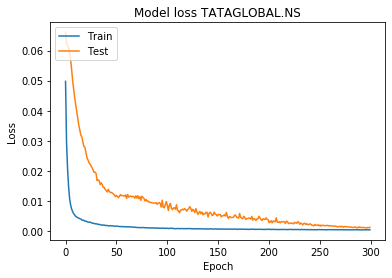


Error is 0.0006444486196272858 (940,) (940,)



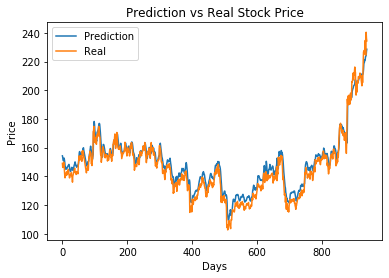

In [6]:
# MARKET=Stock code. Examples:
# 1. TATAGLOBAL.NS   Tata Global Beverages Limited
# 2. UNVR.JK         PT Unilever Indonesia Tbk
# 3. BBCA.JK         PT Bank Central Asia Tbk
# 4. PGAS.JK         PT Perusahaan Gas Negara Tbk

MARKET = 'TATAGLOBAL.NS'
run(MARKET)